_Version log: Branch of V19. Optimisation using MCMC Metropolis._

In [13]:
import sys
import numpy as np
import CS_functions as cs
from matplotlib import pyplot as plt
from scipy import fft as spfft
from tqdm import tqdm

plt.rcParams.update({'font.size':16})
np.set_printoptions(threshold=sys.maxsize)

In [15]:
#file_number = 12
#file_name = "1dmockanderrors{:d}".format(file_number)
#file_type = ".csv"
#target, uncertainties = cs.open_dataset("1dmockanderrors{:d}".format(file_number), ".csv")
#optlocs_file = "data\\" + file_name +"_optlocs.csv"

training_dataset = 3
training_interferograms, training_uncertainty = cs.open_training_dataset(training_dataset)
optlocs_file = "data\\training_set{0:d}_optlocs.csv".format(training_dataset)

In [16]:
iterations = 50000
reduced_points = 8
regularization_coeffient = 1e-4 # DECREASE FOR COMPLEX IMAGES (up to 1e-7 (floating point error?)) INCREASE FOR SIMPLE IMAGES (up to 1e-2)
stepsize = 3
min_seperation = 1

In [17]:
#########INITAILISATION##########

total_points = training_interferograms.shape[-1]

detectors = cs.subsample_1d(total_points, reduced_points, "regular")
original_detectors = np.copy(detectors) #Tell python not to do it's low level memory-saving pointer thing.
detector_configerations = np.array(detectors)

scores = np.array([])
score = cs.evaluate_score(detectors, training_interferograms, training_uncertainty, regularization_coeffient)


#######START MCMC Metropolis###########

for n in tqdm(range(iterations)):
    steps = stepsize #reset steps
    new_detectors = detectors #reset detectors
    new_score = score #reset score

    while steps > 0:
        random_detector = np.random.randint(0, reduced_points) #random number between 0 and reduced_points. Includes 0. Excludes reduced_points

        current = new_detectors[random_detector]
        previous = -1 if random_detector == 0 else new_detectors[random_detector -1]
        next = total_points if random_detector == reduced_points -1 else new_detectors[random_detector +1]

        if previous +min_seperation < current and current < next -min_seperation:
            #detector has space to move forward or back.
            new_detectors[random_detector] += np.random.choice([-1,1])
            steps -= 1
        elif previous +min_seperation < current:
            #detector has space to move back.
            new_detectors[random_detector] -= 1
            steps -= 1
        elif current < next -min_seperation:
            #detector has space to move forward.
            new_detectors[random_detector] += 1
            steps -= 1
        else:
            #detector can't move.
            pass

    new_score = cs.evaluate_score(new_detectors, training_interferograms, training_uncertainty, regularization_coeffient)
    acceptance = np.exp(score -new_score) # Normally MCMC uses `new_score /score` but I am looking for a minimum point so this scheme is better.

    detector_configerations = np.vstack((detector_configerations, new_detectors))

    if acceptance > np.random.rand():
        detectors = new_detectors
        score = new_score

    scores = np.append(scores, score)

100%|██████████| 50000/50000 [3:51:27<00:00,  3.60it/s]  


In [18]:
###FINALISATION AFTER LOOP

best_iteration = np.argmin(scores)
detectors = detector_configerations[best_iteration]
samples = np.full_like(target, np.nan)
samples[detectors] = target[detectors]
result = cs.compressed_sensing(samples, regularization_coeffient)

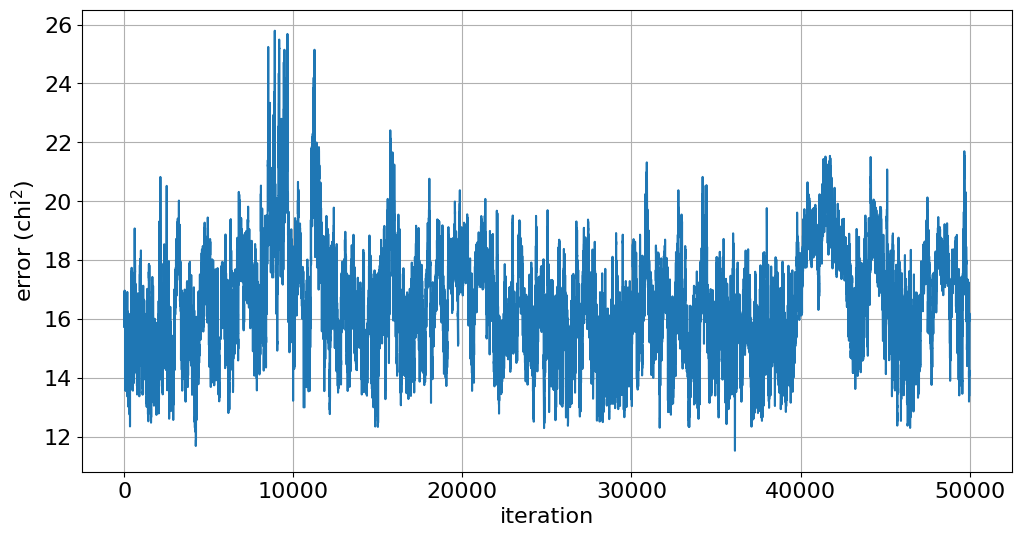

In [19]:
fig, axs = plt.subplots(figsize= (12,6))

axs.plot(scores)
axs.grid(True)
axs.set(ylabel= "error (chi$^2$)", xlabel= "iteration")

plt.show()

In [20]:
cs.append_array_to_csv(detectors, optlocs_file)

print(*detectors, sep= ",")

18,36,52,56,59,71,77,86
